<a href="https://colab.research.google.com/github/Isafon/ECE528/blob/main/ECE528_ASN1_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Upload the Zip file

In [2]:
# If you are using google colab, then you should upload the dataset zip file
from google.colab import files
uploaded = files.upload()

Saving Cats-Dogs-Dataset.zip to Cats-Dogs-Dataset.zip


## 2. Unzip the zip file & peek the dataset

In [3]:
# Once the Cats-Dogs-Dataset.zip file is uploaded, then unzip the file contents
!unzip -q "/content/Cats-Dogs-Dataset.zip" # If you are rerunning the notebook code make sure not run the section 1. and 2. to avoid replacing the entire dataset again
# quick peek at the top-level dataset folder
!ls -lah /content/Cats-Dogs-Dataset/PetImages

total 16K
dr-xr-xr-x 4 root root 4.0K Sep  2 17:01 .
dr-xr-xr-x 3 root root 4.0K Sep  1 21:44 ..
dr-xr-xr-x 4 root root 4.0K Sep  2 17:01 Cat
dr-xr-xr-x 4 root root 4.0K Sep  1 21:40 Dog


## 3. Import the necessay libraries

In [4]:
import os, math, random, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras import Sequential
from keras import layers, regularizers, optimizers
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Rescaling, Normalization, BatchNormalization)

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [5]:
# If using local machine, ensure that the zip file has been unzipped in the same folder as the one which has this notebook
DATASET_PATH = "./Cats-Dogs-Dataset/PetImages"  # relative path (same folder as notebook)

# quick peek at top-level dataset
print("Contents of dataset folder:", os.listdir(DATASET_PATH)) # You can comment this entire cell, if you are using Google Colab

Contents of dataset folder: ['Cat', 'Dog']


## 4. Load the dataset images & define dataset helpers (list files, decode, build & augment data)

In [6]:
dataset_path = '/content/Cats-Dogs-Dataset/PetImages/' # If you are using Google Colab, comment the following line if you are using Google Colab
dataset_path = DATASET_PATH                            # If you are using local machine, comment the above line if you are using local machine

IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
VAL_SPLIT   = 0.2
CLASS_NAMES = ['Cat', 'Dog']
SEED        = 42

def list_images(root_dir, cls_name, split_name):
    """Collect .jpg image paths under e.g. .../Cat/train or .../Dog/test."""
    base = os.path.join(root_dir, cls_name, split_name)
    files = glob.glob(os.path.join(base, '**/*.jpg'), recursive=True)
    return sorted(files)

def make_labeled_list(root_dir, split_name):
    """Return (paths, labels) where labels are 0 for 'Cat', 1 for 'Dog'."""
    paths, labels = [], []
    for idx, cls in enumerate(CLASS_NAMES):
        ps = list_images(root_dir, cls, split_name)
        paths += ps
        labels += [idx] * len(ps)
    return paths, labels

def _decode_by_ext(path, bytes_):
    return tf.image.decode_jpeg(bytes_, channels=3)

# --- Use it inside your decode_image ---
def decode_image(path, label):
    bytes_ = tf.io.read_file(path)
    img = _decode_by_ext(path, bytes_)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, tf.cast(label, tf.float32)

def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_hue(img, 0.05)
    return img, label

def make_dataset(paths, labels, shuffle=False, batch_size=BATCH_SIZE, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=max(1, len(paths)), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE).ignore_errors()
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

## 5. Split the dataset into train, validation and test sets

In [7]:
# Gather files from your original layout
train_paths_all, train_labels_all = make_labeled_list(dataset_path, 'train')
test_paths_all,  test_labels_all  = make_labeled_list(dataset_path, 'test')

# Shuffle once, then split train → (train/val)
idx = list(range(len(train_paths_all)))
random.shuffle(idx)
train_paths_all  = [train_paths_all[i]  for i in idx]
train_labels_all = [train_labels_all[i] for i in idx]

val_count  = int(math.floor(len(train_paths_all) * VAL_SPLIT))
val_paths  = train_paths_all[:val_count]
val_labels = train_labels_all[:val_count]
train_paths= train_paths_all[val_count:]
train_labels=train_labels_all[val_count:]

# Build datasets; repeat train/val since we will set steps_per_epoch
train_ds = make_dataset(train_paths, train_labels, shuffle=True, augment=True).repeat()
val_ds   = make_dataset(val_paths, val_labels, shuffle=False, augment=False).repeat()
test_ds  = make_dataset(test_paths_all, test_labels_all, shuffle=False, augment=False)

# Epoch sizing
steps_per_epoch  = math.ceil(len(train_paths) / BATCH_SIZE)
validation_steps = math.ceil(len(val_paths)   / BATCH_SIZE)
test_steps       = math.ceil(len(test_paths_all) / BATCH_SIZE)

# Info
print("Class names:", CLASS_NAMES)
print("Num training images:", len(train_paths))
print("Num validation images:", len(val_paths))
print("Num test images:", len(test_paths_all))
print("Num steps per epoch:", steps_per_epoch)
print("Num validation steps:", validation_steps)
print("Num test steps:", test_steps)

Class names: ['Cat', 'Dog']
Num training images: 2000
Num validation images: 500
Num test images: 500
Num steps per epoch: 63
Num validation steps: 16
Num test steps: 16


## 6. Build & Compile the CNN model


In [54]:
# Build your model
try:
    H, W = IMG_SIZE
except NameError:
    H, W = 224, 224

model = keras.Sequential([
    keras.layers.Input(shape=(H, W, 3)),
    keras.layers.Rescaling(1./255),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3), # Slightly increased dropout

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'), # Added another conv layer
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3), # Added dropout

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = optimizers.Adam(learning_rate=0.00005) # Further reduced learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,121 (25.99 MB)

 Trainable params: 6,812,161 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

## 7. Train the CNN model

In [ ]:
#Feel free to tune hyperparameters
EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - accuracy: 0.5200 - loss: 1.5583 - val_accuracy: 0.5000 - val_loss: 1.0643
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6038 - loss: 0.9313 - val_accuracy: 0.5663 - val_loss: 0.9254
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6108 - loss: 0.9120 - val_accuracy: 0.5321 - val_loss: 1.0069
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6228 - loss: 0.8852 - val_accuracy: 0.5321 - val_loss: 1.1288
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6454 - loss: 0.8737 - val_accuracy: 0.5763 - val_loss: 1.1600
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6615 - loss: 0.8753 - val_accuracy: 0.5964 - val_loss: 1.2483
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6718 - loss: 0.8740 - val_accuracy: 0.6365 - val_loss: 1.1120
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6860 - loss: 0.8566 - val_accuracy: 0.6426 -

## 8. Visualization of results after training

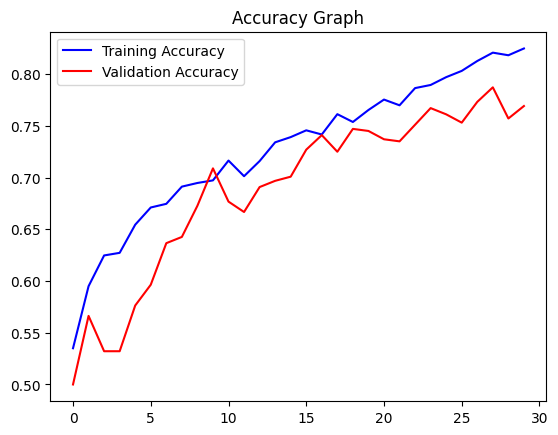

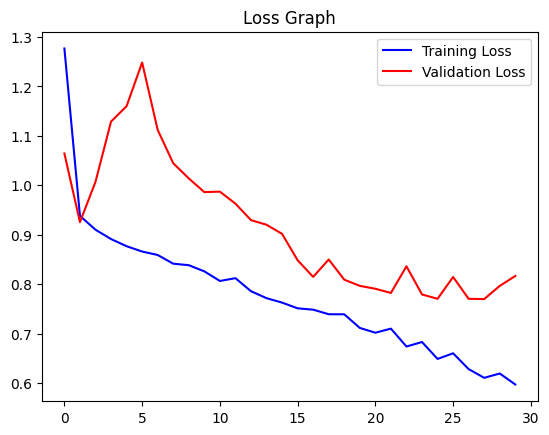

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## 9. Evaluate the CNN model

In [57]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds, steps=test_steps, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8317 - loss: 0.6765
Test Loss: 0.7527
Test Accuracy: 0.8016


## 10. Confusion Matrix & Classification Report

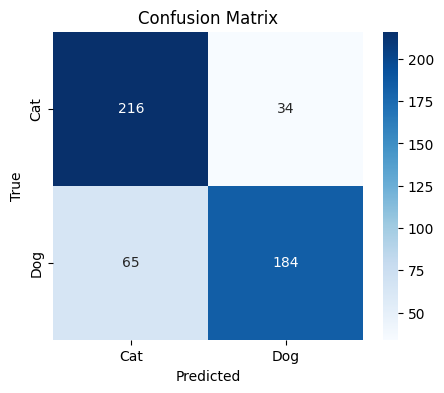

              precision    recall  f1-score   support

         Cat       0.77      0.86      0.81       250
         Dog       0.84      0.74      0.79       249

    accuracy                           0.80       499
   macro avg       0.81      0.80      0.80       499
weighted avg       0.81      0.80      0.80       499



In [58]:
# Collect predictions on the whole test set
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0).squeeze()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Detailed metrics
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

## 11. Predict Five Random Test Images

615.jpg -> Pred: Cat (p=0.063) | True: Cat
380.jpg -> Pred: Cat (p=0.096) | True: Cat
4857.jpg -> Pred: Cat (p=0.264) | True: Dog
355.jpg -> Pred: Cat (p=0.046) | True: Cat
4856.jpg -> Pred: Dog (p=1.000) | True: Dog


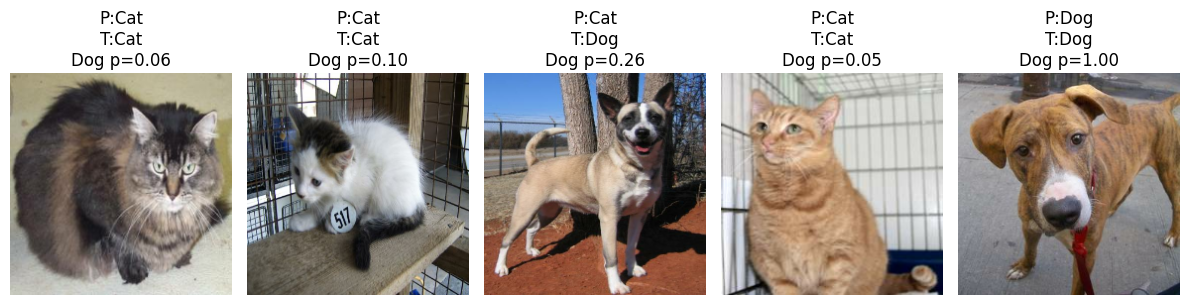

In [59]:
def preprocess_path(path):
    bytes_ = tf.io.read_file(path)
    img = _decode_by_ext(path, bytes_)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img

k = 5
idxs = random.sample(range(len(test_paths_all)), k)
sel_paths  = [test_paths_all[i]  for i in idxs]
sel_labels = [test_labels_all[i] for i in idxs]  # 0=Cat, 1=Dog

infer_ds = (tf.data.Dataset.from_tensor_slices(sel_paths)
            .map(lambda p: preprocess_path(p), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(k))

probs = model.predict(infer_ds, verbose=0).squeeze()
preds = (probs >= 0.5).astype(int)
pred_names = [CLASS_NAMES[p] for p in preds]
true_names = [CLASS_NAMES[int(t)] for t in sel_labels]

for i, p in enumerate(sel_paths):
    print(f"{os.path.basename(p)} -> Pred: {pred_names[i]} (p={probs[i]:.3f}) | True: {true_names[i]}")

# visualize
plt.figure(figsize=(12, 6))
for i, path in enumerate(sel_paths):
    img = preprocess_path(path).numpy()
    if img.dtype != 'uint8' and img.max() > 1.0:
        img = img / 255.0  # safety for display
    plt.subplot(1, k, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"P:{pred_names[i]}\nT:{true_names[i]}\nDog p={probs[i]:.2f}")
plt.tight_layout()
plt.show()